In [ ]:
### In this file I create and configure the next models: Imagenet-Mnist-HandPD, Imagenet-Mnist, MNIST.

# setup for repetitive results
from numpy.random import seed
seed(3)
from tensorflow.random import set_seed
set_seed(2)
import os, sys

In [ ]:
# setup environment
from google.colab import drive
drive.mount('/content/mydrive/', force_remount = True)
path = '/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/'
sys.path.insert(0, path)
%load_ext tensorboard

Mounted at /content/mydrive/
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# importing necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorboard as tb
from keras import backend as C
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import make_axes_locatable
C.clear_session() # claar previous session


In [ ]:
# data engineering
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train_ = []
for i in x_train[0:5000]:
  img = cv2.resize(i, (224,224), interpolation = cv2.INTER_AREA)
  img = np.stack((img,)*3, axis=-1)
  x_train_.append(img)

x_test_ = []
for i in x_test[0:1000]:
  img = cv2.resize(i, (224,224), interpolation = cv2.INTER_AREA)
  img = np.stack((img,)*3, axis=-1)
  x_test_.append(img)

y_train, y_test = y_train[0:5000], y_test[0:1000]

x_train = np.array(x_train_).reshape(5000,224,224,3)
x_test = np.array(x_test_).reshape(1000,224,224,3)


y_test.shape

(1000,)

In [ ]:
# one hot encoding for Y data
y_train_new, y_test_new = [], []
for i in y_train:
    pattern = [0] * 10
    pattern[i] = 1
    y_train_new.append(pattern)

for i in y_test:
    pattern = [0] * 10
    pattern[i] = 1
    y_test_new.append(pattern)

y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)
y_train_new[0] 

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
#  initializing of base model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = True

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#  configuring top layers of the model
from tensorflow.keras import layers, models
C.clear_session()
model = models.Sequential([base_model])
model.add(GlobalAveragePooling2D())
model.add(Dense(100, use_bias=True, activation='relu'))
model.add(Dropout(0.3)) #Dropout layer helps to solve overfitting
model.add(Dense(20, activation='relu'))

model.add((Dense(10, activation='softmax')))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                        

In [ ]:
#  tuning setup for the whole model
optimizer = Adam(learning_rate=0.001) # choosing appropriate optimizer
C.clear_session()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy',],) #model compile with choosen settings
path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/'

# model checkpoint to save weights during training
model_checkpoint = ModelCheckpoint(filepath=path + 'trained_Imagenet_MNIST_full{epoch:02d}.h5',
                                   monitor='val_accuracy',
                                   verbose=2,
                                   save_best_only=False,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

#  reducing learning rate for better model fit perfomance
reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, verbose=1, min_delta=0.00005, cooldown=0, min_lr=0.000001)

# fitting the model on the tarining data with further evaluation on the test data during training process
hist = model.fit(x=x_train,y=y_train_new, epochs=50, batch_size=64, callbacks=[reduce_learning_rate, model_checkpoint], validation_data=(x_test,y_test_new), shuffle=False)

Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 7.4730 - accuracy: 0.1876
Epoch 1: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/trained_Imagenet_MNIST_full01.h5
79/79 [==============================] - 36s 443ms/step - loss: 7.4730 - accuracy: 0.1876 - val_loss: 1.7655 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 2/50
79/79 [==============================] - ETA: 0s - loss: 1.6919 - accuracy: 0.3660
Epoch 2: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/trained_Imagenet_MNIST_full02.h5
79/79 [==============================] - 35s 437ms/step - loss: 1.6919 - accuracy: 0.3660 - val_loss: 1.3493 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 3/50
79/79 [==============================] - ETA: 0s - loss: 1.1662 - accuracy: 0.5878
Epoch 3: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/trained_Imagenet_MNIST_full03.h5
79/79 [==============================] - 35s 438ms/step - loss: 1.16

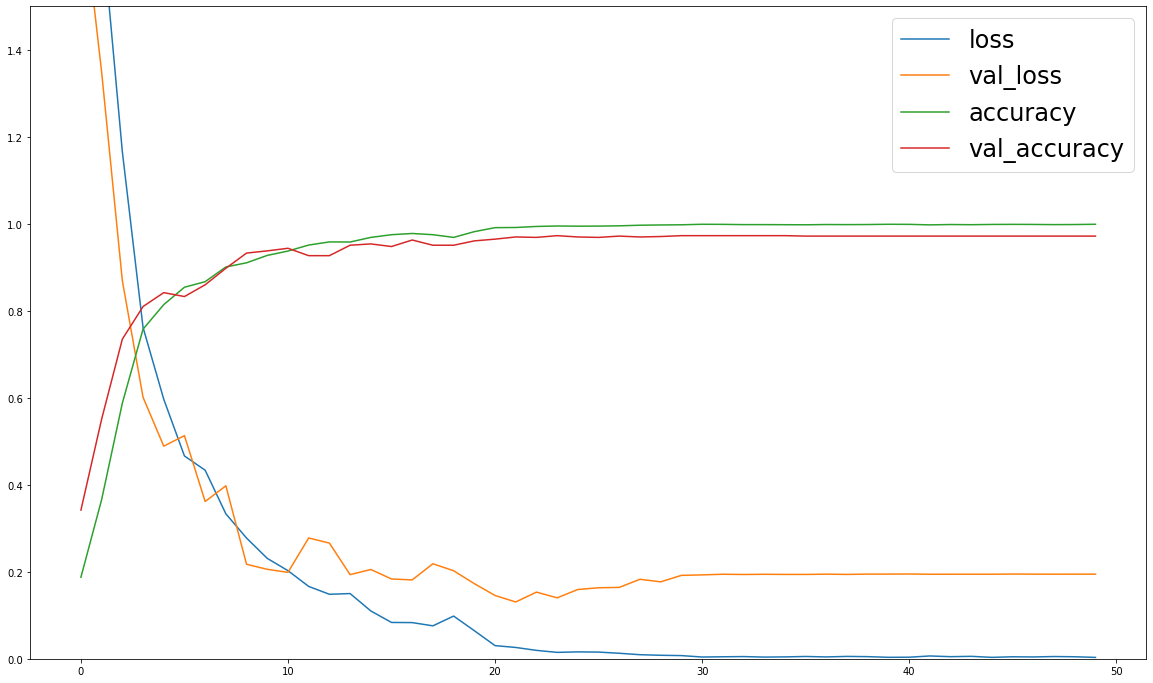

In [ ]:
# plotting and saving of training process
plt.figure(figsize=(20,12))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.ylim(0,1.5)
plt.legend(loc='upper right', prop={'size': 24})
plt.savefig('/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/Imagenet_MNIST_learning_history.svg')
plt.savefig('/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/Imagenet_MNIST_learning_history.png')
plt.show()
accuracies = [hist.history['accuracy']]

In [ ]:
# defining of training samples path of the HPD dataset
test_path = r"/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/MATO/HandPDSpiralk/k_5_/test"
train_path = r"/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/MATO/HandPDSpiralk/k_5_/train"

In [ ]:
# Preprocessing input
trdata = ImageDataGenerator(rotation_range=13)
traindata = trdata.flow_from_directory(directory=train_path,target_size=(224,224), class_mode='binary',batch_size=2)
tsdata = ImageDataGenerator(rotation_range=13)
testdata = tsdata.flow_from_directory(directory=test_path, target_size=(224,224), class_mode='binary',batch_size=20)

Found 208 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [ ]:
# extracting the base model from the whole model
trained_base_model = model.layers[0]

In [ ]:
# configuring model for target dataset (HPD)
for layer in trained_base_model.layers[:]:
    layer.trainable = True

pretuned_model = models.Sequential([trained_base_model])
pretuned_model.add(GlobalAveragePooling2D())
pretuned_model.add(Dense(100, activation='relu'))
pretuned_model.add(Dense(20, activation='relu'))
pretuned_model.add((Dense(1, activation='sigmoid')))
C.clear_session()
# setting up the optimizer for the target dataset
optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.1, epsilon=1e-07, centered=False)
# compilling model with choosen settings
pretuned_model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['binary_accuracy',],)

path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/'
logs = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/logs/'

model_checkpoint = ModelCheckpoint(filepath=path + 'trained_MNIST_PAHAW_full_model{epoch:02d}.h5',
                                   verbose=2,
                                   save_best_only=False,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.4, patience=3, verbose=1, min_delta=0.00005, cooldown=0, min_lr=0.00000001)
hist = pretuned_model.fit_generator(traindata, epochs=50, callbacks=[reduce_learning_rate, model_checkpoint], validation_data=testdata, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 1.1397 - binary_accuracy: 0.5769
Epoch 1: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/trained_MNIST_PAHAW_full_model01.h5
104/104 [==============================] - 104s 965ms/step - loss: 1.1397 - binary_accuracy: 0.5769 - val_loss: 0.6935 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 0.8959 - binary_accuracy: 0.5192
Epoch 2: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/trained_MNIST_PAHAW_full_model02.h5
104/104 [==============================] - 11s 101ms/step - loss: 0.8959 - binary_accuracy: 0.5192 - val_loss: 0.6941 - val_binary_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 2.5424 - binary_accuracy: 0.5048
Epoch 3: saving model to /content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/trained_MNIST_PAHAW_full_model03.h5

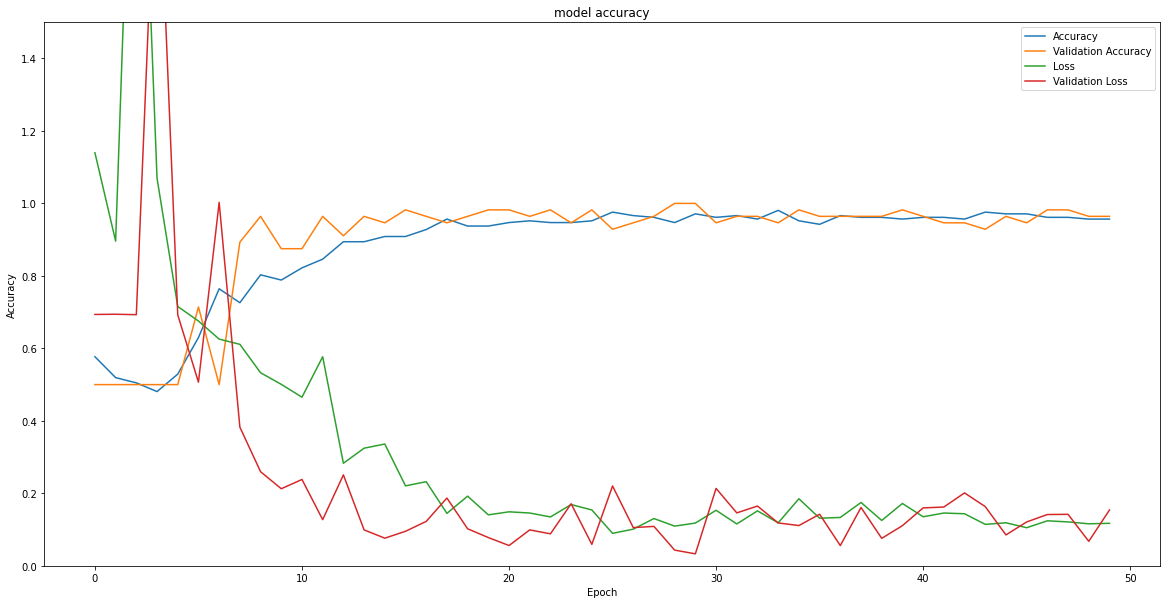

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(hist.history["binary_accuracy"], label = 'binary_accuracy')
plt.plot(hist.history['val_binary_accuracy'], label = 'val_binary_accuracy')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0, 1.5)
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [ ]:
# extracting statistics from stored mediator dataset models

import os
from tensorflow import keras
path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/models/'
files = [file for _, _, file in os.walk(path)][0]

# collecting of model names from data storage to the lists
MNIST_models = [file  for file in files if file[0:27] == "trained_Imagenet_MNIST_full"]
MNIST_PAHAW_models = [file  for file in files if file[0:19] == "trained_MNIST_PAHAW"]

# dictionaries for calculated statictics
MNIST_weights_average = {}
MNIST_weights_min = {}
MNIST_weights_max = {}
MNIST_weights_std = {}
# defining final layer numbers without globalaveragepooling layer and dropout layer
layer_numbers = [2,4]
MNIST_models.sort()

# cycle for calculating statistics through received models
for idx, file in enumerate(MNIST_models):
    
    loaded_model = keras.models.load_model(path + file)
    weights_arr_average = []
    weights_arr_min = []
    weights_arr_max = []
    weights_arr_std = []
    base_model = loaded_model.layers[0]
    for layer_number, layer in enumerate(base_model.get_weights()):

        try:
            layer_weights = base_model.layers[layer_number].trainable_weights[0]
            weights_arr_max.append(np.abs(np.max(layer_weights)))
            weights_arr_min.append(np.abs(np.min(layer_weights)))
            weights_arr_average.append(np.abs((np.max(layer_weights) - np.min(layer_weights)/np.min(layer_weights))))
            weights_arr_std.append(np.abs(np.std(layer_weights)))

        except Exception as e:
            pass

    for l in layer_numbers:
        
        layer_weights = loaded_model.layers[l].trainable_weights[0]
        weights_arr_max.append(np.abs(np.max(layer_weights)))
        weights_arr_min.append(np.abs(np.min(layer_weights)))
        weights_arr_average.append(np.abs((np.max(layer_weights) - np.min(layer_weights)/np.min(layer_weights))))
        weights_arr_std.append(np.abs(np.std(layer_weights)))

    print(int(file[-5:-3]))
    MNIST_weights_average[int(file[-5:-3])] = weights_arr_average
    MNIST_weights_min[int(file[-5:-3])] = weights_arr_min
    MNIST_weights_max[int(file[-5:-3])] = weights_arr_max
    MNIST_weights_std[int(file[-5:-3])] = weights_arr_std

['trained_Imagenet_MNIST_full01.h5', 'trained_Imagenet_MNIST_full02.h5', 'trained_Imagenet_MNIST_full03.h5', 'trained_Imagenet_MNIST_full04.h5', 'trained_Imagenet_MNIST_full05.h5', 'trained_Imagenet_MNIST_full06.h5', 'trained_Imagenet_MNIST_full07.h5', 'trained_Imagenet_MNIST_full08.h5', 'trained_Imagenet_MNIST_full09.h5', 'trained_Imagenet_MNIST_full10.h5', 'trained_Imagenet_MNIST_full11.h5', 'trained_Imagenet_MNIST_full12.h5', 'trained_Imagenet_MNIST_full13.h5', 'trained_Imagenet_MNIST_full14.h5', 'trained_Imagenet_MNIST_full15.h5', 'trained_Imagenet_MNIST_full16.h5', 'trained_Imagenet_MNIST_full17.h5', 'trained_Imagenet_MNIST_full18.h5', 'trained_Imagenet_MNIST_full19.h5', 'trained_Imagenet_MNIST_full20.h5', 'trained_Imagenet_MNIST_full21.h5', 'trained_Imagenet_MNIST_full22.h5', 'trained_Imagenet_MNIST_full23.h5', 'trained_Imagenet_MNIST_full24.h5', 'trained_Imagenet_MNIST_full25.h5', 'trained_Imagenet_MNIST_full26.h5', 'trained_Imagenet_MNIST_full27.h5', 'trained_Imagenet_MNIST_ful

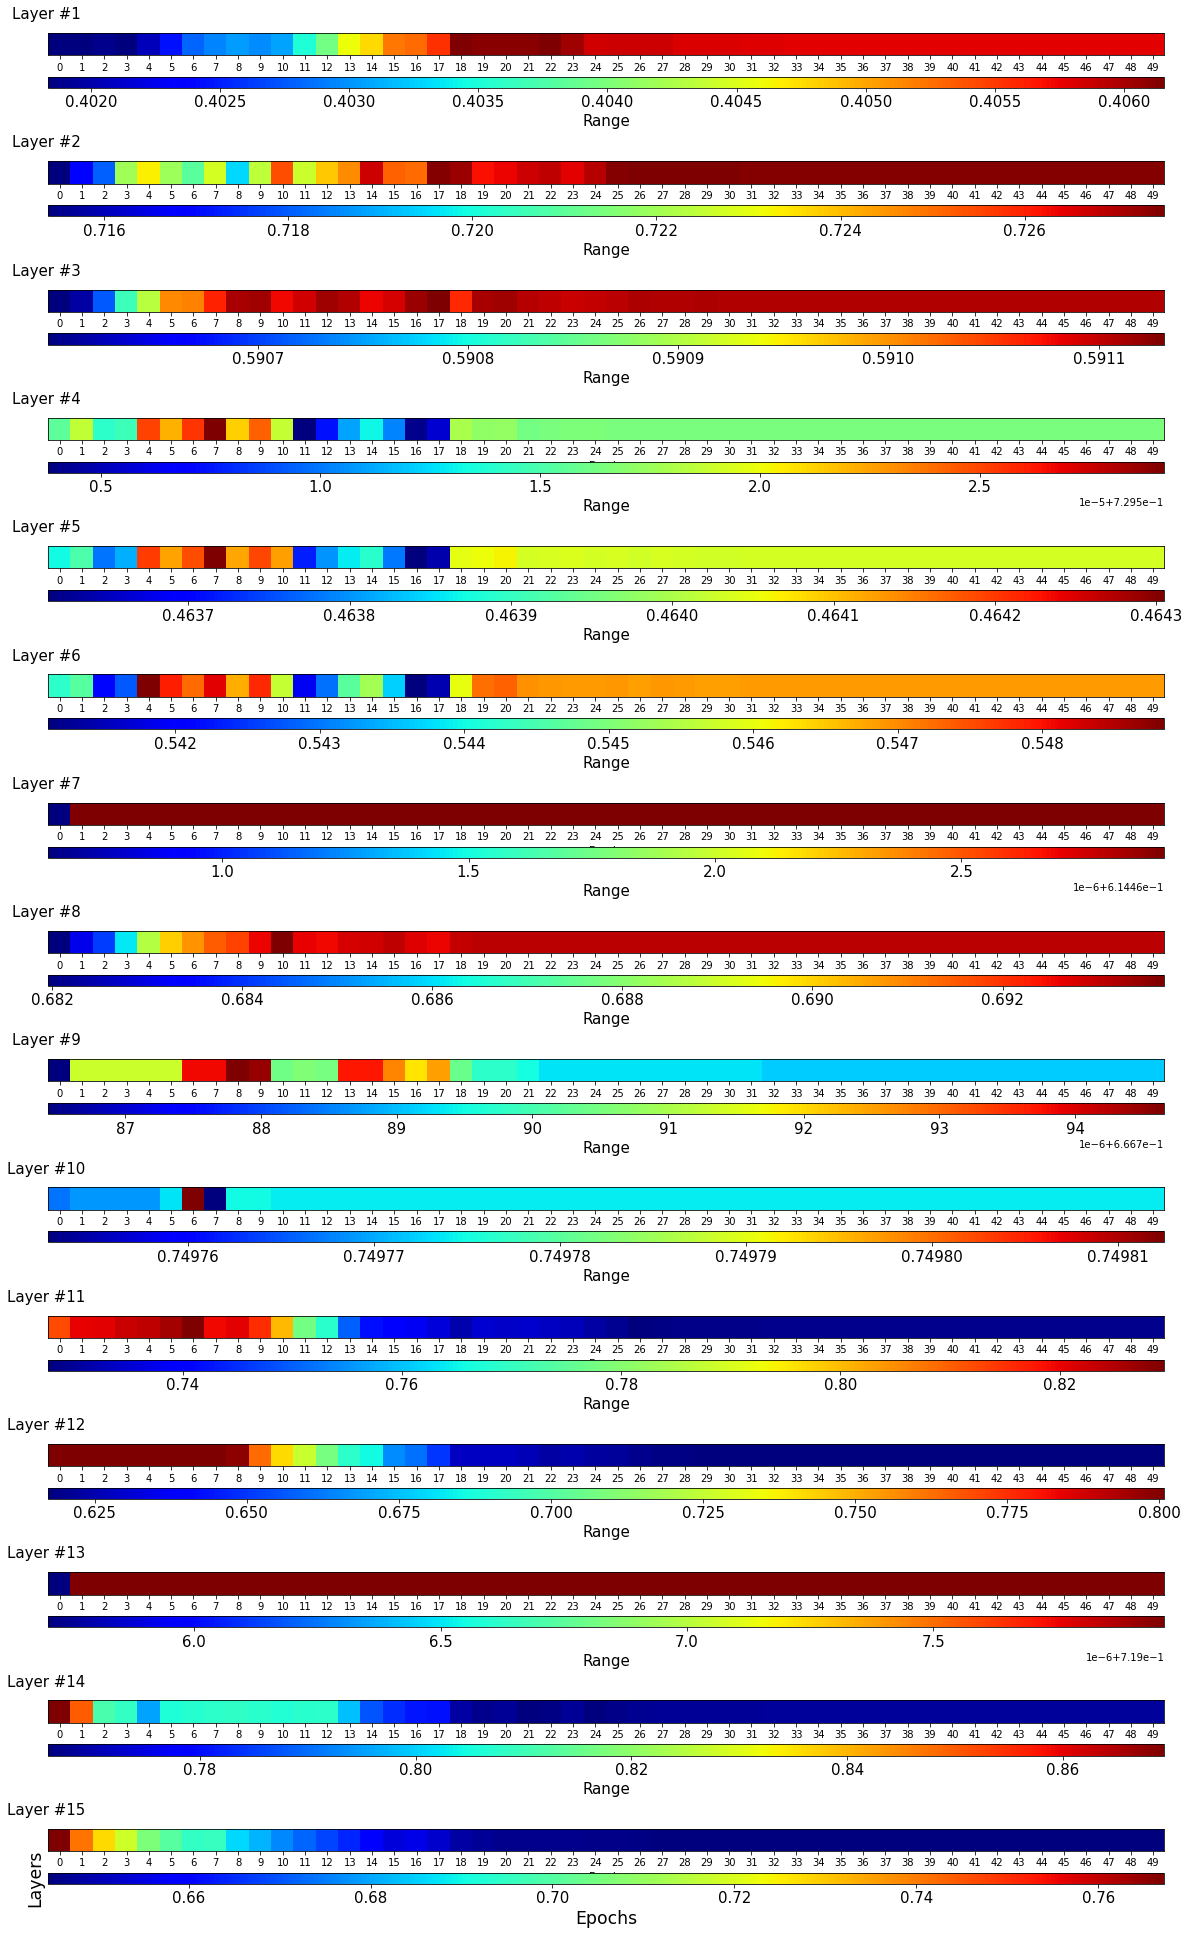

In [ ]:
# visualization of the obtained statistics of the base model
average_weights_array = np.array([ i for i in MNIST_weights_average.values()]).T
fig, ax = plt.subplots(len(average_weights_array), figsize=(20,35))

results_path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/'
for idx, layer_weights in enumerate(average_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path + 'Imagenet_MNIST_average_weights.png')
fig.savefig(results_path + 'Imagenet_MNIST_average_weights.svg')
fig.show()

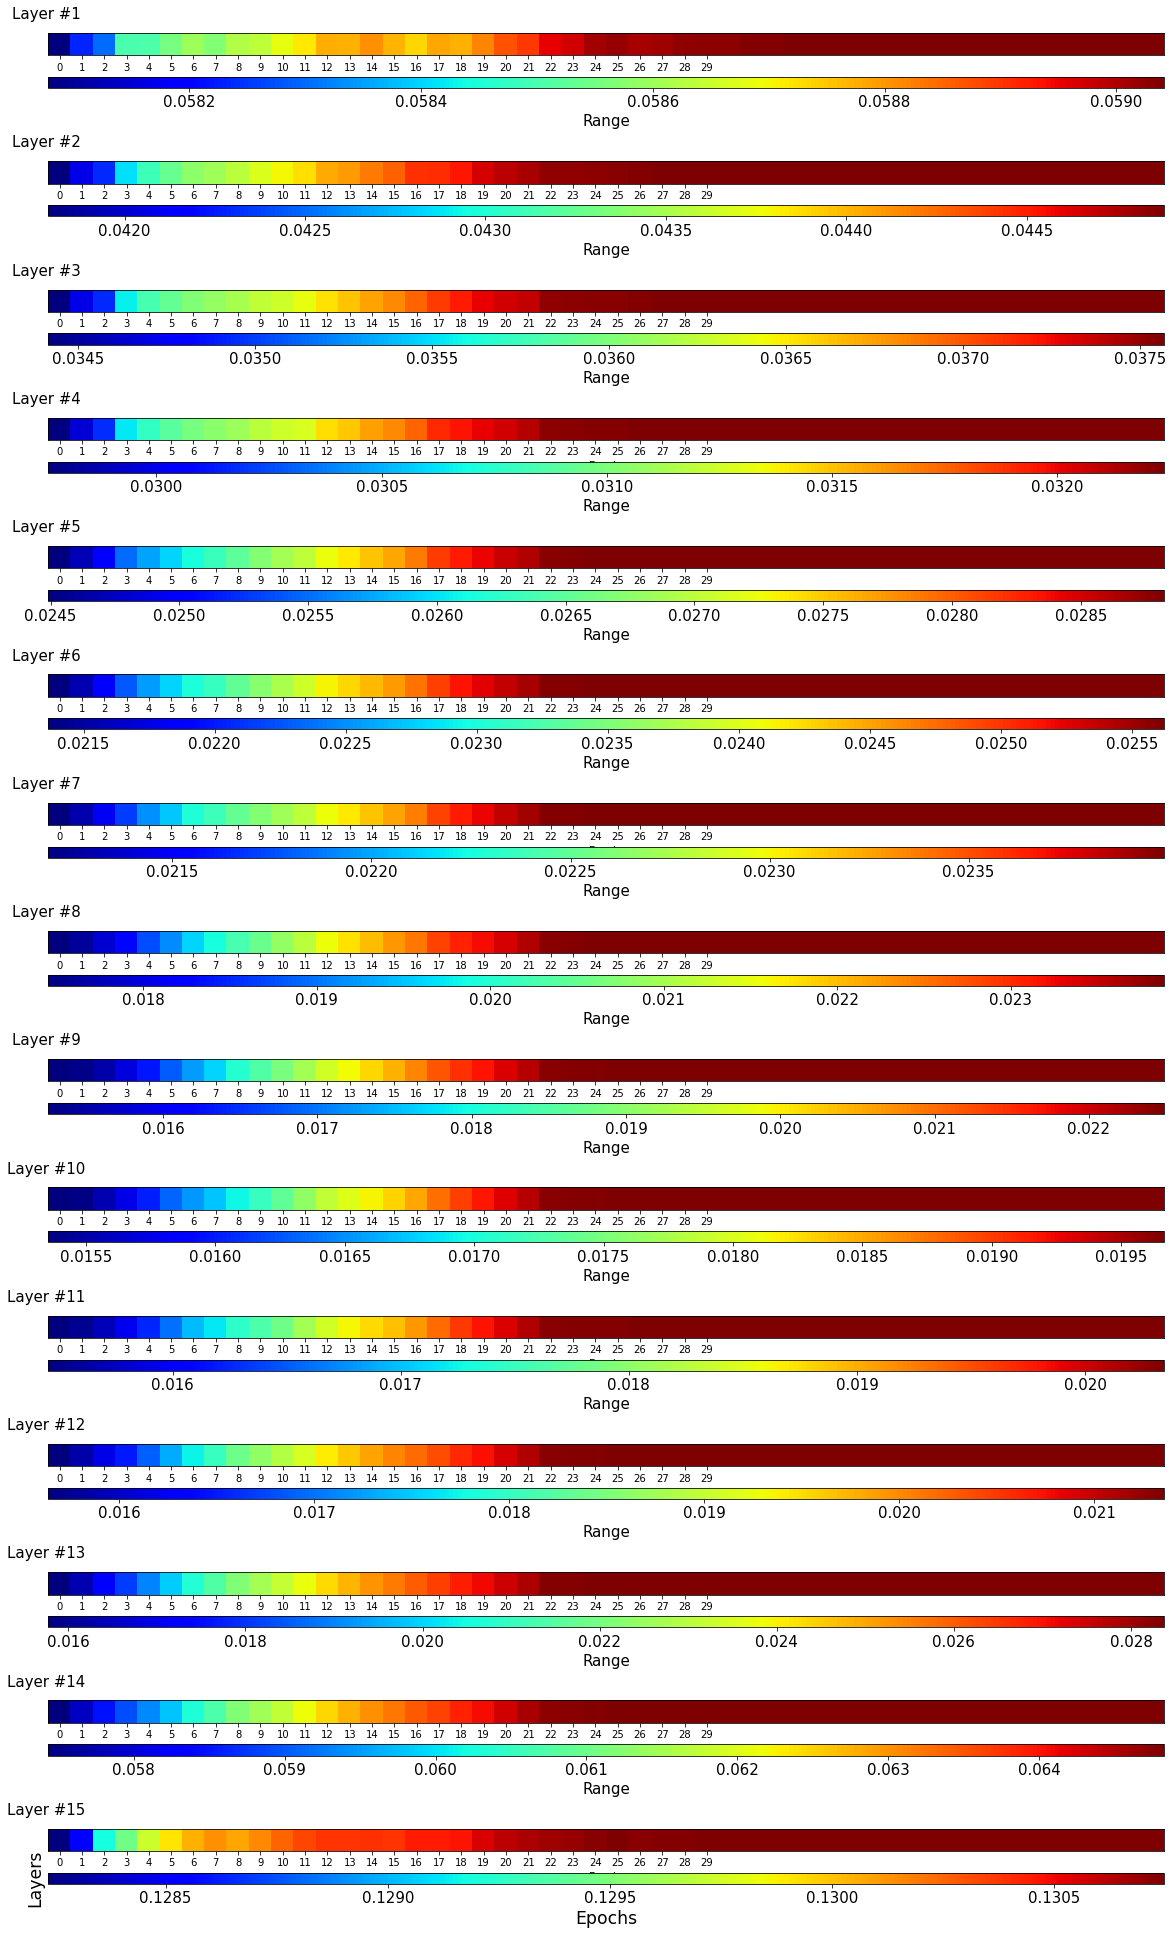

In [ ]:
std_weights_array = np.array([ i for i in MNIST_weights_std.values()]).T
fig, ax = plt.subplots(len(std_weights_array), figsize=(20,35))

results_path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/'
for idx, layer_weights in enumerate(std_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path + 'Imagenet_MNIST_std_weights.png')
fig.savefig(results_path + 'Imagenet_MNIST_std_weights.svg')
fig.show()
# 

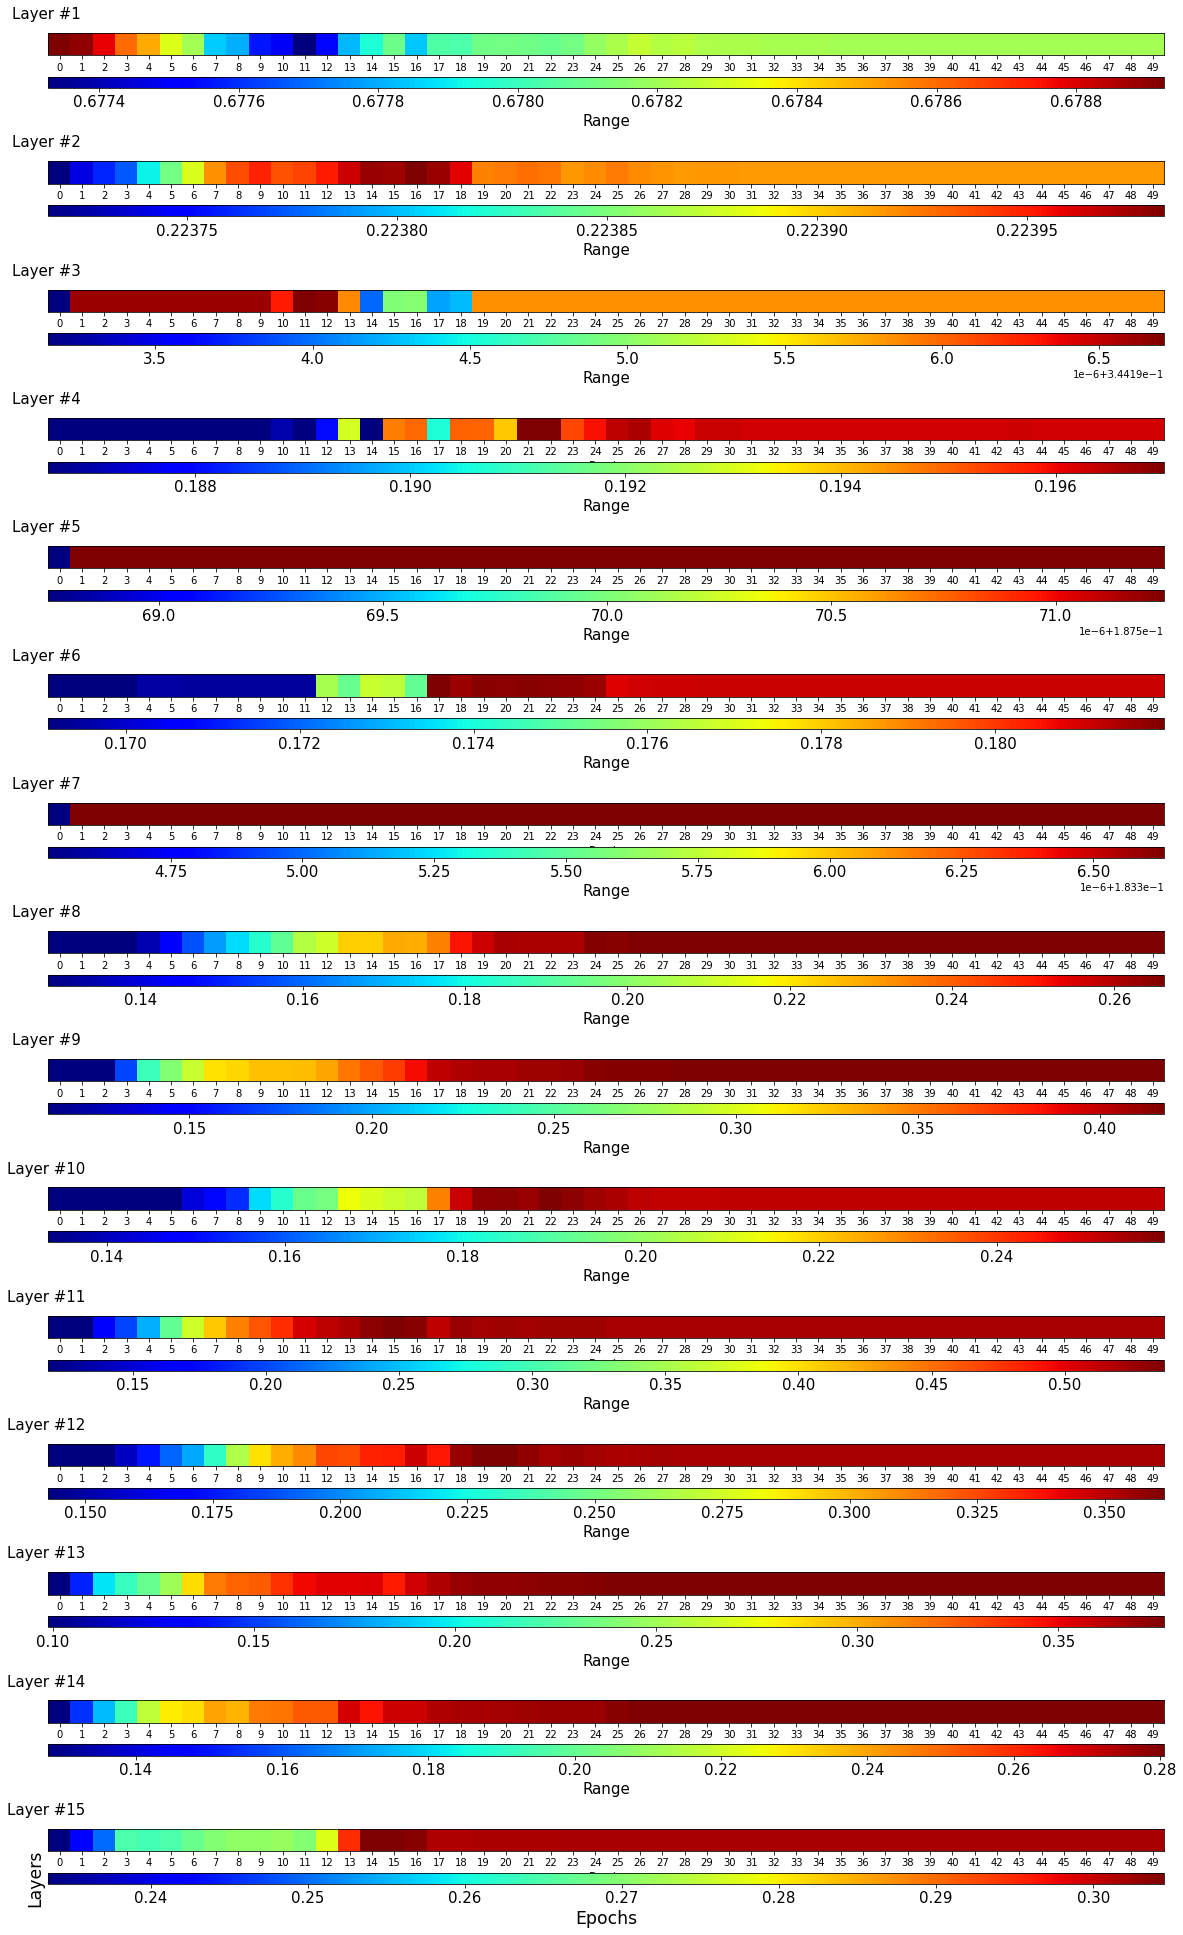

In [ ]:
min_weights = np.array([ i for i in MNIST_weights_min.values()]).T
fig, ax = plt.subplots(len(min_weights), figsize=(20,35))

results_path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/'
for idx, layer_weights in enumerate(min_weights):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path + 'Imagenet_MNIST_min_weights.png')
fig.savefig(results_path + 'Imagenet_MNIST_min_weights.svg')
fig.show()
# 

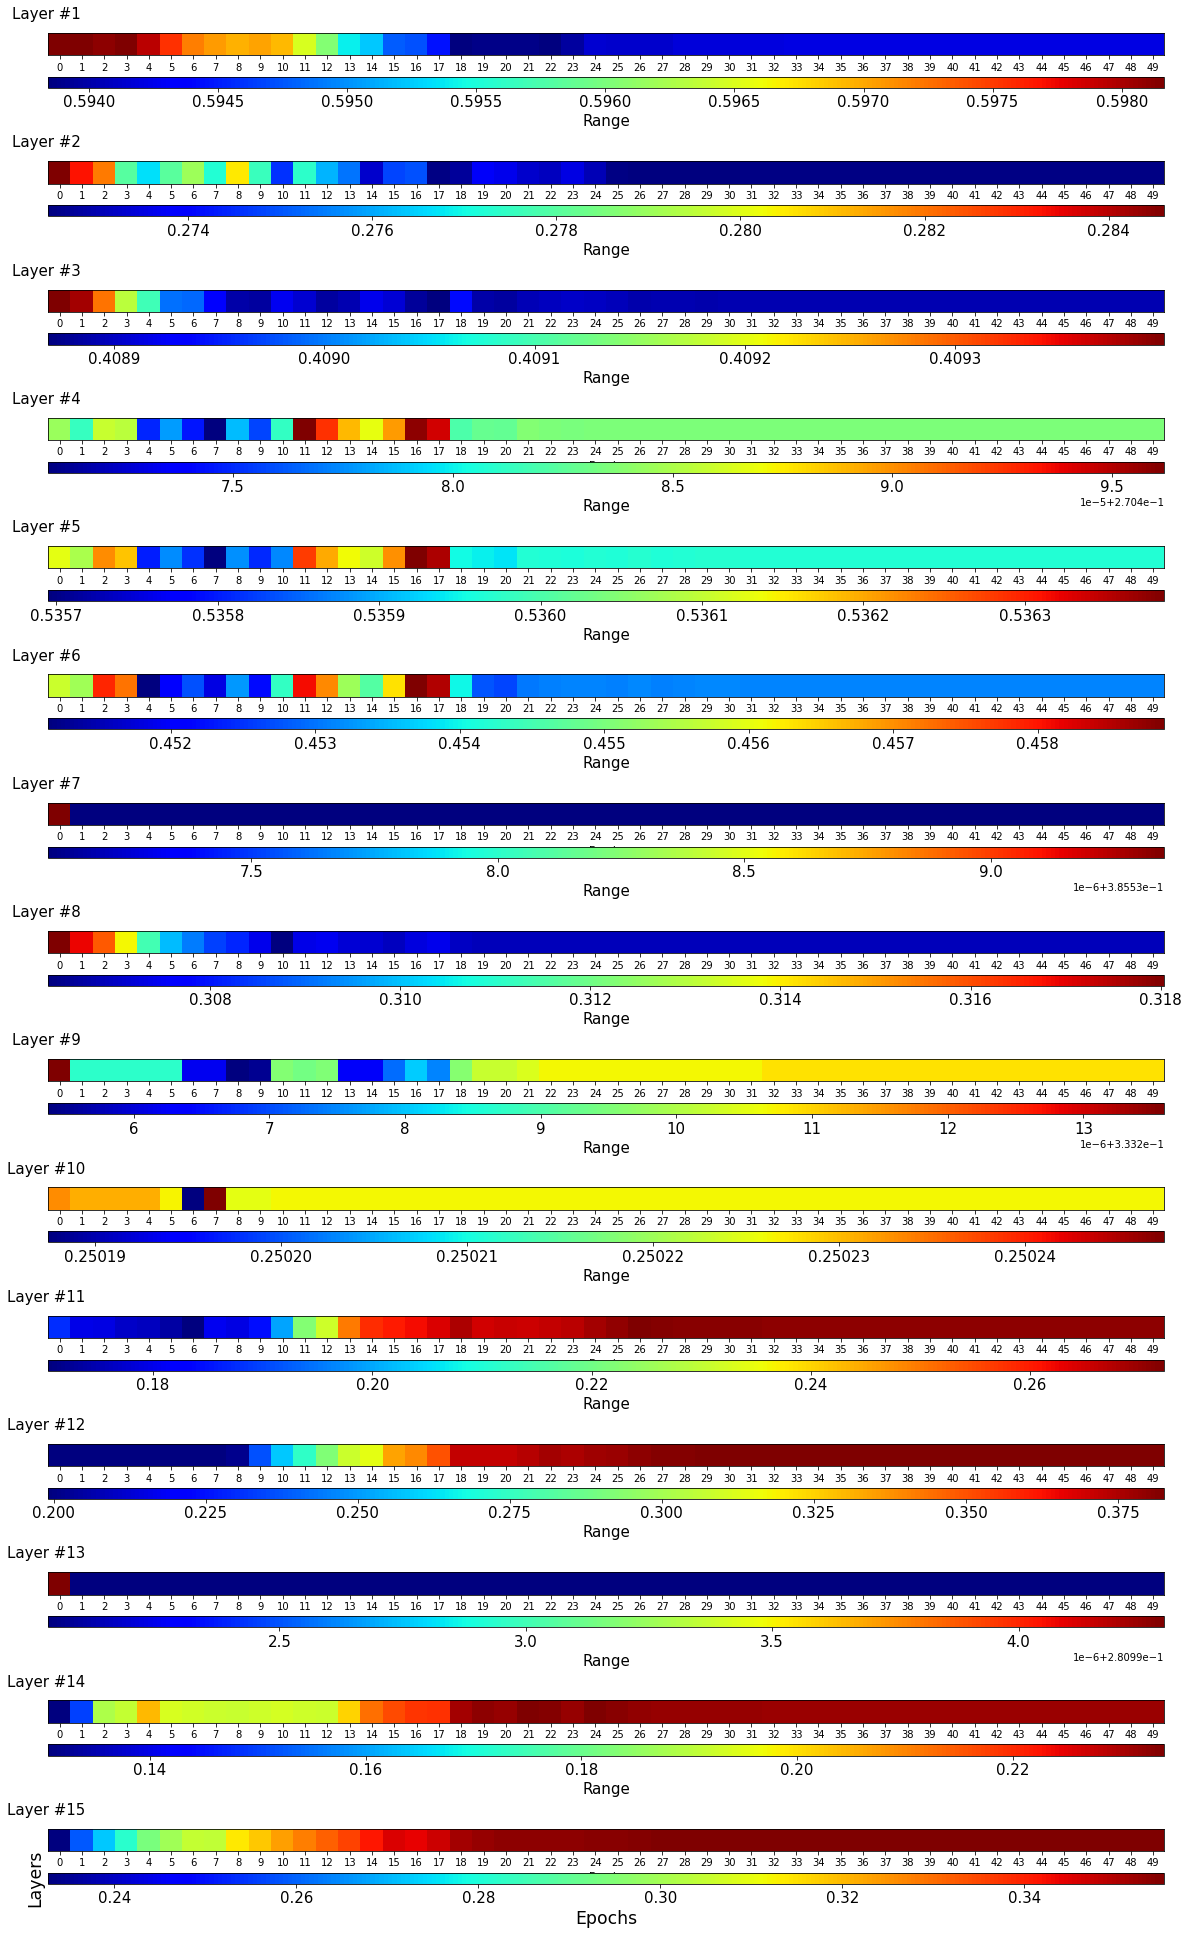

In [ ]:
max_weights_array = np.array([ i for i in MNIST_weights_max.values()]).T
fig, ax = plt.subplots(len(max_weights_array), figsize=(20,35))

results_path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/'
for idx, layer_weights in enumerate(max_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path + 'Imagenet_MNIST_max_weights.png')
fig.savefig(results_path + 'Imagenet_MNIST_max_weights.svg')
fig.show()
# 

In [ ]:
# extracting statistics from stored target dataset models
MNIST_PAHAW_weights_average = {}
MNIST_PAHAW_weights_min = {}
MNIST_PAHAW_weights_max = {}
MNIST_PAHAW_weights_std = {}
layer_numbers = [2,4]
all_weights = []
MNIST_PAHAW_weights_ = {}
MNIST_PAHAW_models.sort()
for idx, file in enumerate(MNIST_PAHAW_models):
    
    loaded_model = keras.models.load_model(path + file)
    weights_arr_average = []
    weights_arr_min = []
    weights_arr_max = []
    weights_arr_std = []
    base_model = loaded_model.layers[0]
    for layer_number, layer in enumerate(base_model.get_weights()):

        try:
            layer_weights = base_model.layers[layer_number].trainable_weights[0]
            weights_arr_max.append(np.abs(np.max(layer_weights)))
            weights_arr_min.append(np.abs(np.min(layer_weights)))
            weights_arr_average.append(np.abs((np.max(layer_weights) - np.min(layer_weights)/np.min(layer_weights))))
            weights_arr_std.append(np.abs(np.std(layer_weights)))

        except Exception as e:
            pass        

    for l in layer_numbers:
        layer_weights = loaded_model.layers[l].trainable_weights[0]
        weights_arr_max.append(np.abs(np.max(layer_weights)))
        weights_arr_min.append(np.abs(np.min(layer_weights)))
        weights_arr_average.append(np.abs((np.max(layer_weights) - np.min(layer_weights)/np.min(layer_weights))))
        weights_arr_std.append(np.abs(np.std(layer_weights)))


    print(int(file[-5:-3]))
    MNIST_PAHAW_weights_average[int(file[-5:-3])] = weights_arr_average
    MNIST_PAHAW_weights_min[int(file[-5:-3])] = weights_arr_min
    MNIST_PAHAW_weights_max[int(file[-5:-3])] = weights_arr_max
    MNIST_PAHAW_weights_std[int(file[-5:-3])] = weights_arr_std

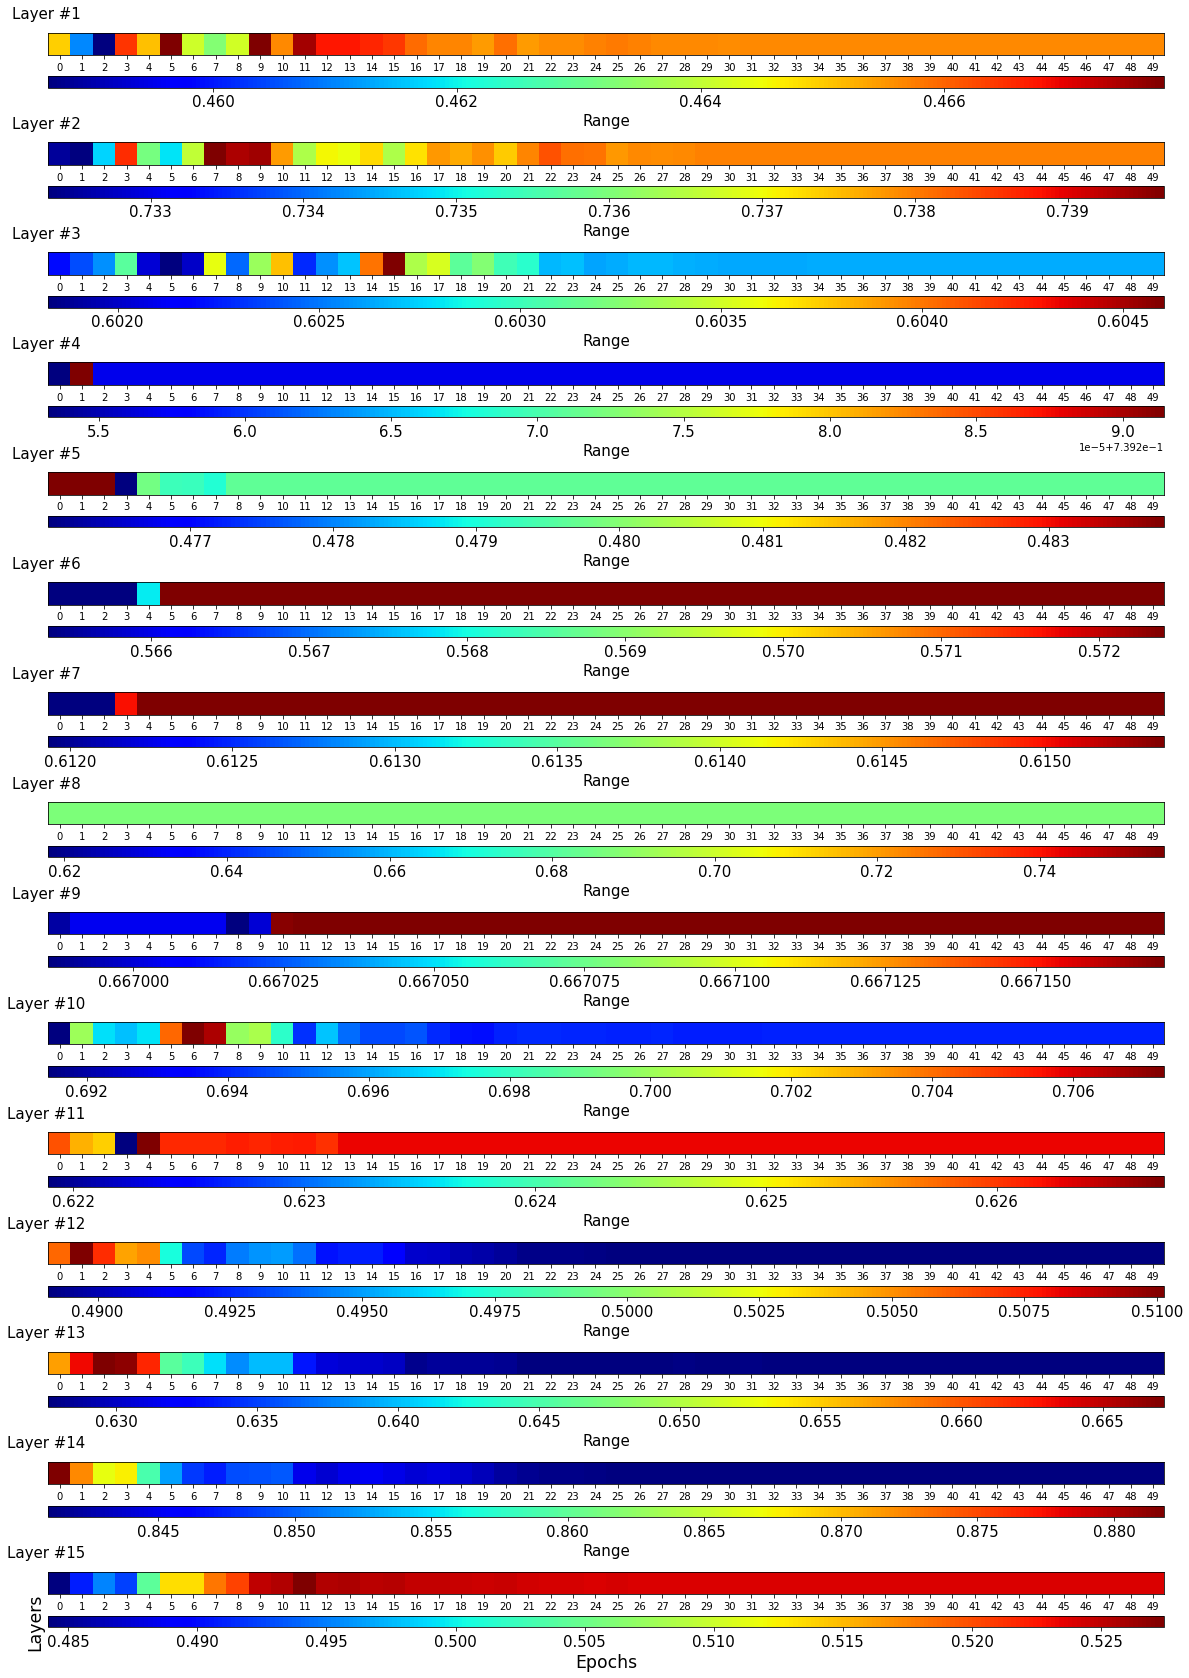

In [ ]:
# visualizating of the obtained statistics of the whole model trained on the target dataset
average_weights_array = np.array([ i for i in MNIST_PAHAW_weights_average.values()]).T
fig, ax = plt.subplots(len(average_weights_array), figsize=(20,30))

results_path = r'/content/mydrive/MyDrive/ColabNotebooks/BachelorDegree/results/'
for idx, layer_weights in enumerate(average_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path + 'Imagenet_MNIST_Pahaw_average_weights.png')
fig.show()


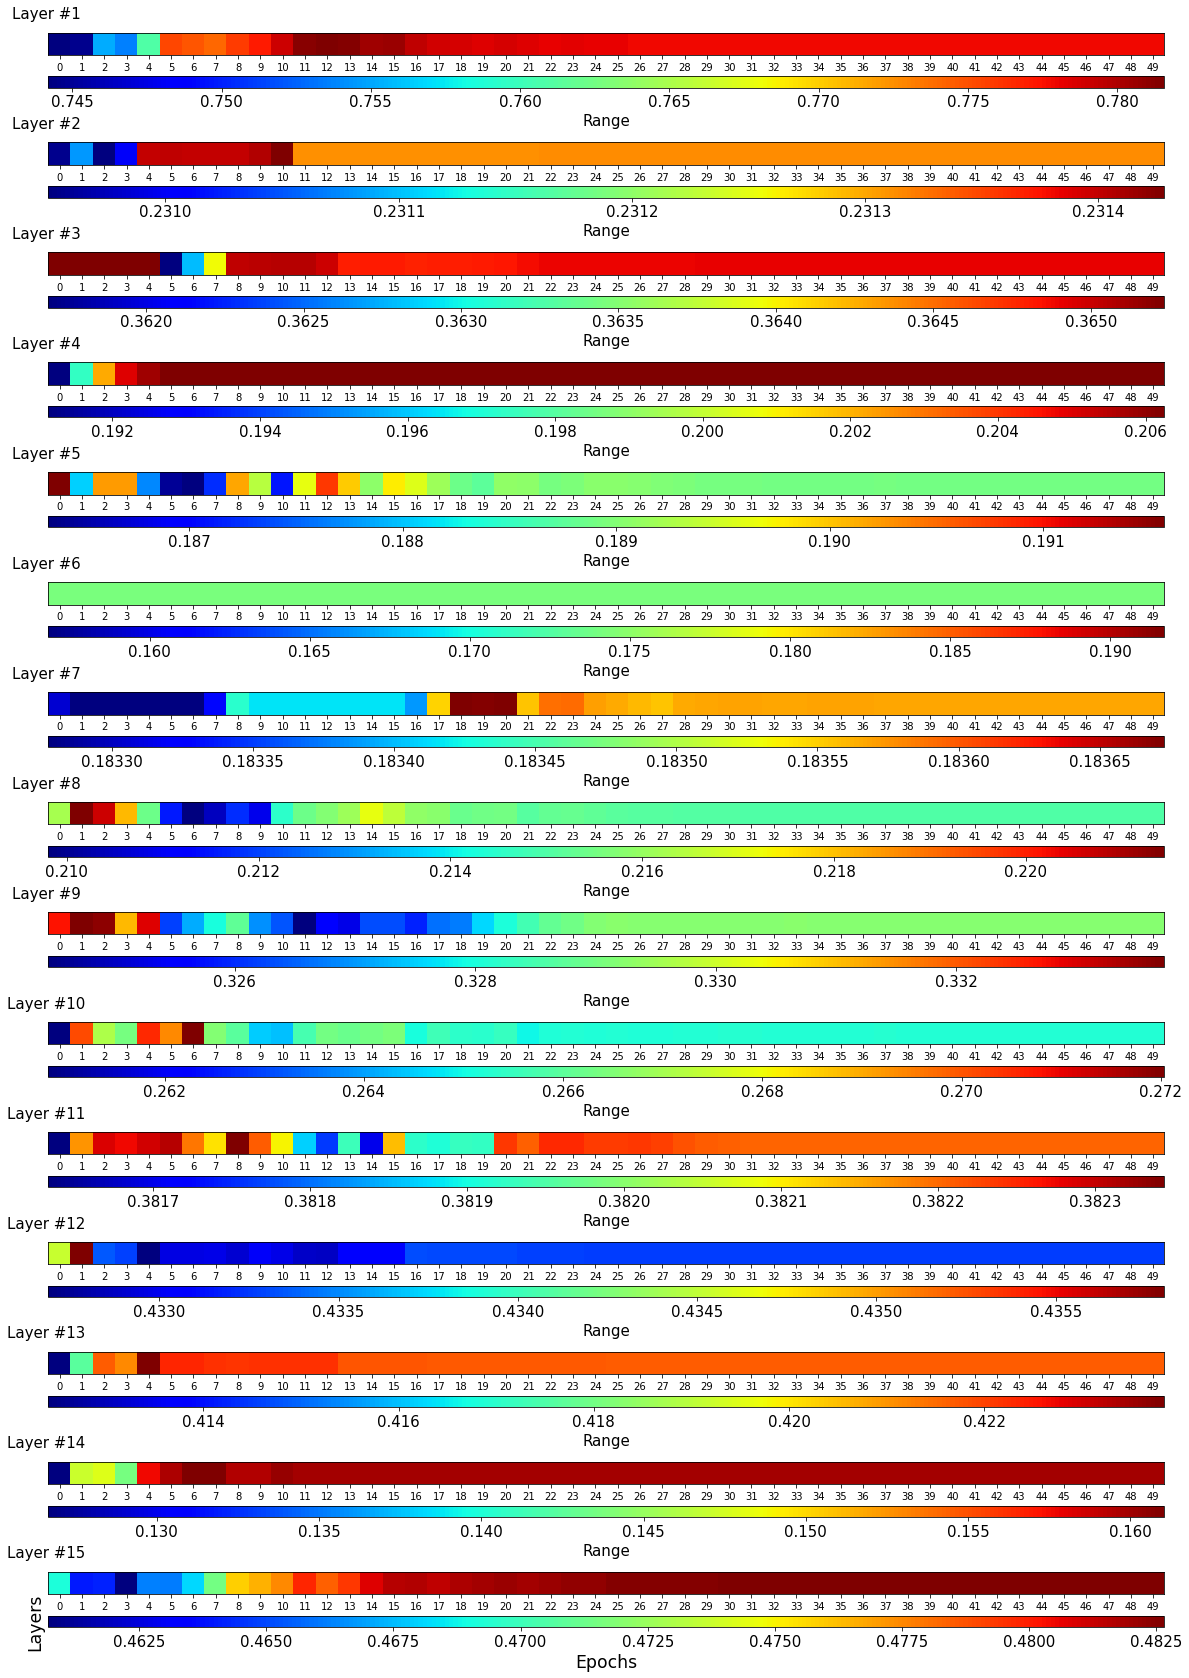

In [ ]:
min_weights_array = np.array([ i for i in MNIST_PAHAW_weights_min.values()]).T
fig, ax = plt.subplots(len(min_weights_array), figsize=(20,30))


for idx, layer_weights in enumerate(min_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path +'Imagenet_MNIST_Pahaw_min_weights.png')

fig.show()
# 

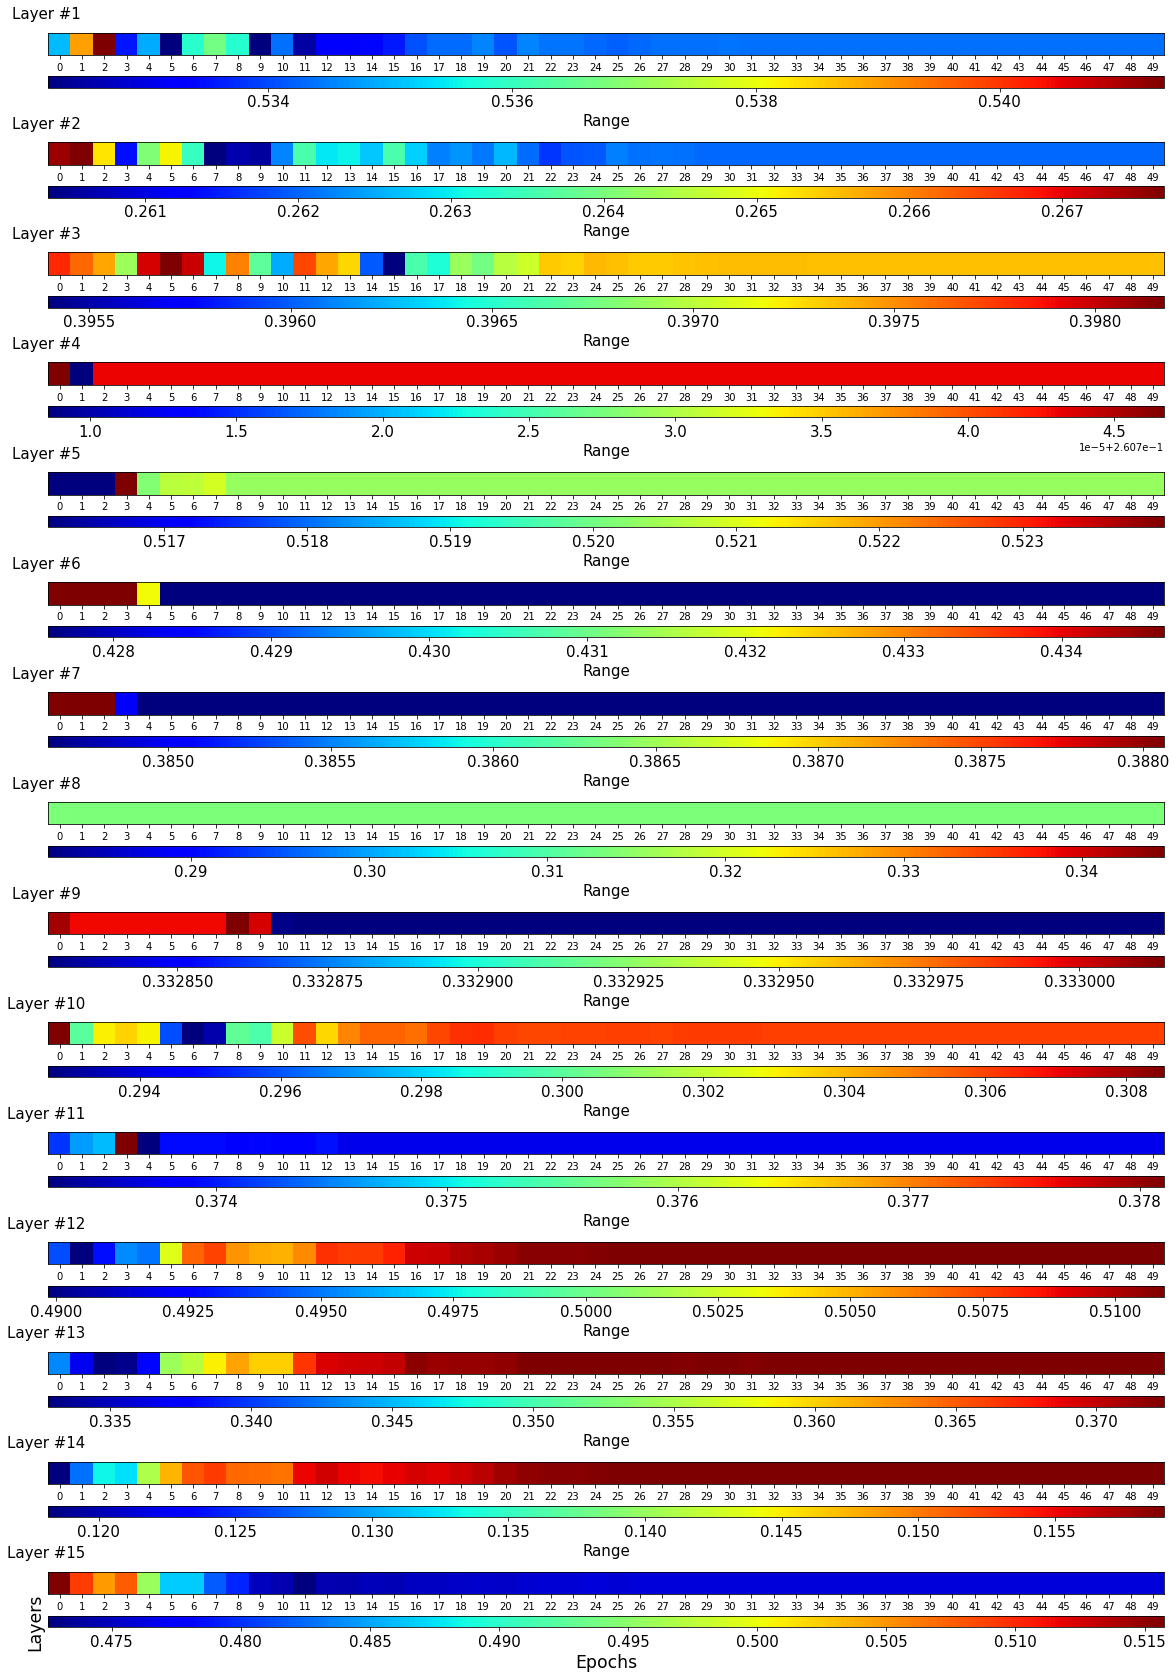

In [ ]:
max_weights_array = np.array([ i for i in MNIST_PAHAW_weights_max.values()]).T
fig, ax = plt.subplots(len(max_weights_array), figsize=(20,30))


for idx, layer_weights in enumerate(max_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path +'Imagenet_MNIST_Pahaw_max_weights.png')

fig.show()
# 

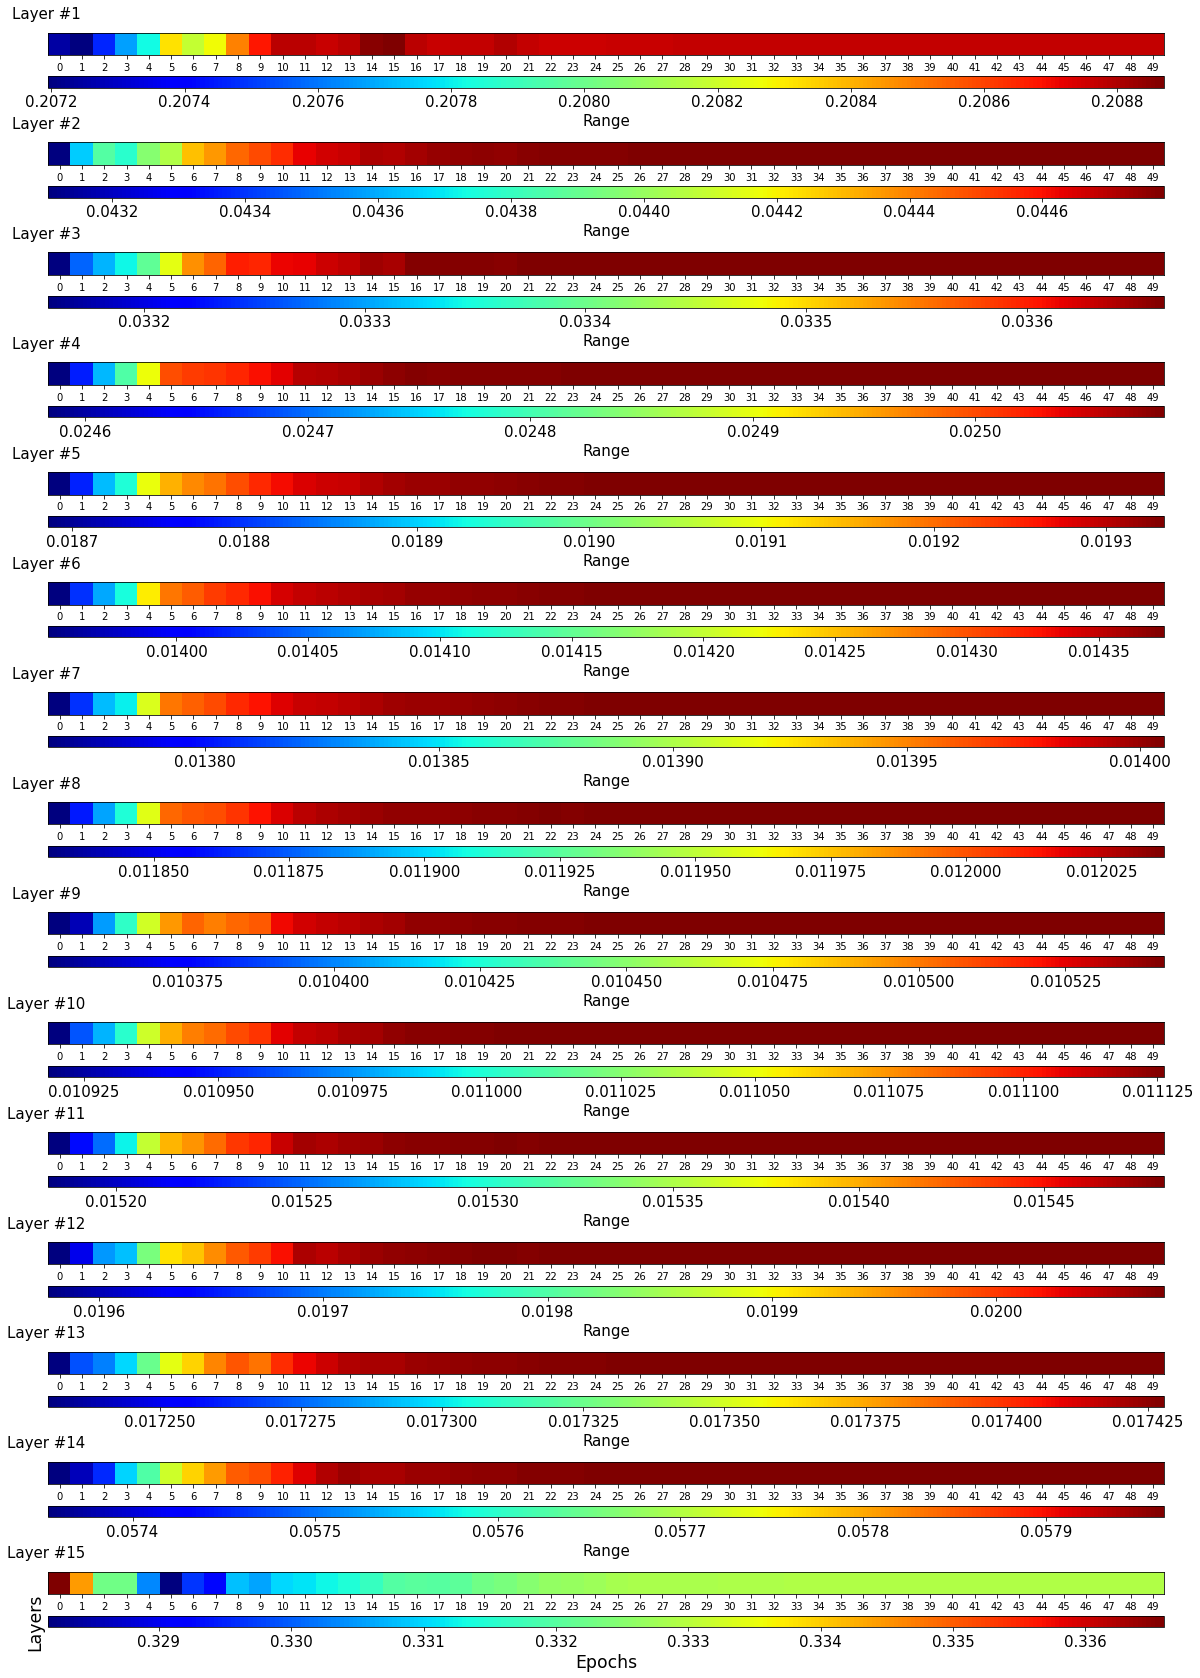

In [ ]:
std_weights_array = np.array([ i for i in MNIST_PAHAW_weights_std.values()]).T
fig, ax = plt.subplots(len(std_weights_array), figsize=(20,30))


for idx, layer_weights in enumerate(std_weights_array):

    img = ax[idx].imshow([layer_weights], cmap='jet')
    label = ax[idx].set_ylabel(f'Layer #{idx+1}',rotation = 'horizontal',fontsize=15,labelpad = 2.0)
    label.set_position((1,1.5))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_xticks(range(50))
    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="50%", pad=0.3)
    cbar = fig.colorbar(img, orientation = 'horizontal', cax=cax)
    cbar.set_label("Range",fontsize=15)
    cbar.ax.tick_params(labelsize=15) 
    

plt.xlabel("Epochs", fontsize = 'xx-large')
plt.ylabel("Layers", fontsize = 'xx-large')
fig.savefig(results_path +'Imagenet_MNIST_Pahaw_std_weights.png')

fig.show()
# 